# Machine Learning - Prediction of Energy Consumption

## The dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Reading data into a pandas DataFrame, and inspecting the columns

import pandas as pd
df = pd.read_csv("data_electricity.csv")

## Index data by timestamp
datetime = pd.to_datetime(df.Date * (10 ** 9))
df['Datetime'] = datetime    # This timestamp should not be used during training
df.set_index('Datetime', inplace=True)

print("Dataset has", len(df), "entries.")

print(f"\n\t{'Column':20s} | {'Type':8s} | {'Min':12s} | {'Max':12s}\n")
for col_name in df.columns:
    col = df[col_name]
    print(f"\t{col_name:20s} | {str(col.dtype):8s} | {col.min():12.1f} | {col.max():12.1f}")
    
print(f"\nData starts from: {df.index[0]}, until {df.index[-1]}")
      
print(df.columns)


Dataset has 419403 entries.

	Column               | Type     | Min          | Max         

	Date                 | int64    | 1262487660.0 | 1514947775.0
	Consumption_MW       | float64  |         44.0 |      26209.0
	Coal_MW              | float64  |       -485.0 |       5702.0
	Gas_MW               | float64  |       -414.0 |       2666.0
	Hidroelectric_MW     | float64  |          0.0 |       4728.0
	Nuclear_MW           | float64  |          0.0 |       1450.0
	Wind_MW              | float64  |       -521.0 |       7944.0
	Solar_MW             | float64  |         -6.0 |        859.0
	Biomass_MW           | float64  |          0.0 |        110.0
	Production_MW        | float64  |          0.0 |      11295.0

Data starts from: 2010-01-03 03:01:00, until 2018-01-03 02:49:35
Index(['Date', 'Consumption_MW', 'Coal_MW', 'Gas_MW', 'Hidroelectric_MW',
       'Nuclear_MW', 'Wind_MW', 'Solar_MW', 'Biomass_MW', 'Production_MW'],
      dtype='object')


Next, we perform the split between a training and testing set. As mentioned before, the data expands over 8 years. The first 7 years will be kept for training, while the last year will become the testing set.

In [3]:
## Split data into train / test 

from dateutil.relativedelta import relativedelta

eval_from = df.index.max() + relativedelta(months=-12)  # Here we set the 12 months threshold
train_df = df[df.index < eval_from]
test_df = df[df.index >= eval_from]

print(f"Train data: {train_df.index.min()} -> {train_df.index.max()} | {len(train_df)} samples.")
print(f"Test data: {test_df.index.min()} -> {test_df.index.max()} | {len(test_df)} samples.")

Train data: 2010-01-03 03:01:00 -> 2017-01-03 02:40:14 | 365939 samples.
Test data: 2017-01-03 02:50:04 -> 2018-01-03 02:49:35 | 53464 samples.


## Visualising the data

We can also have a look at individual features to get a feel for the data. For example, we can take a look at how the "Consumption MW" or "Production MW" columns look like. The code below provides a visualization function, together with plots for the consumption and production columns for the entire dataset, over 8 years.

C:\Users\kaila\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
C:\Users\kaila\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\kaila\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


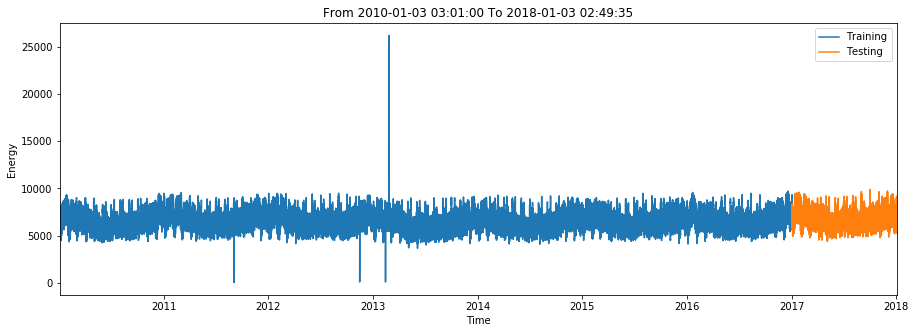

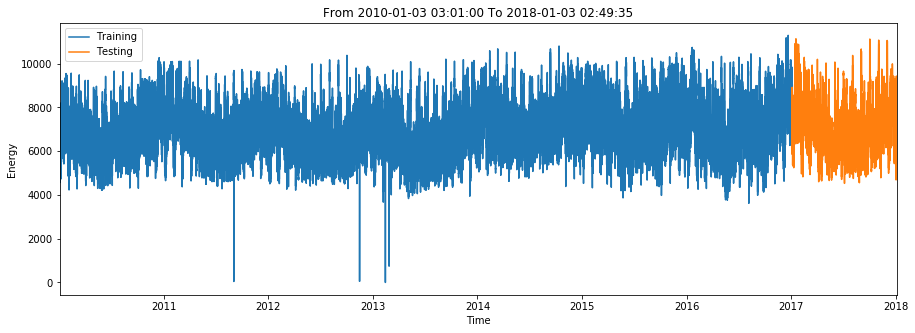

In [4]:
## Helper function for plotting the training and test data for a certain colum
def plot_interval(base_data, test, date_from, date_to, column='Consumption_MW', title=None):
    plt.figure(figsize=(15,5))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Energy')
    plt.plot(base_data.index, getattr(base_data, column), label='Training')
    plt.plot(test.index, getattr(test, column), label='Testing')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)
    
    
plot_interval(train_df, test_df, train_df.index[0], test_df.index[-1], 'Consumption_MW')
plot_interval(train_df, test_df, train_df.index[0], test_df.index[-1], 'Production_MW')


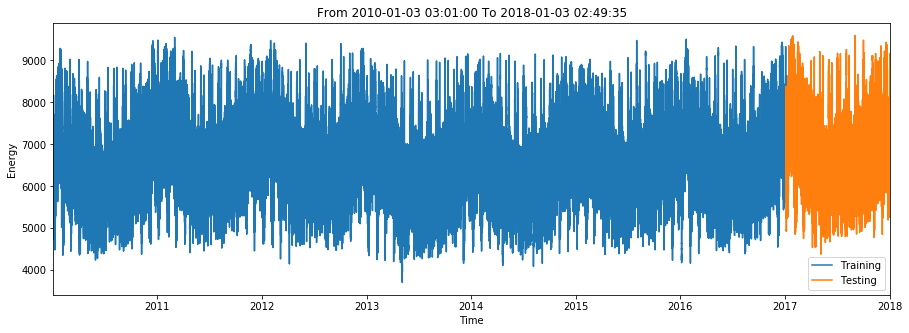

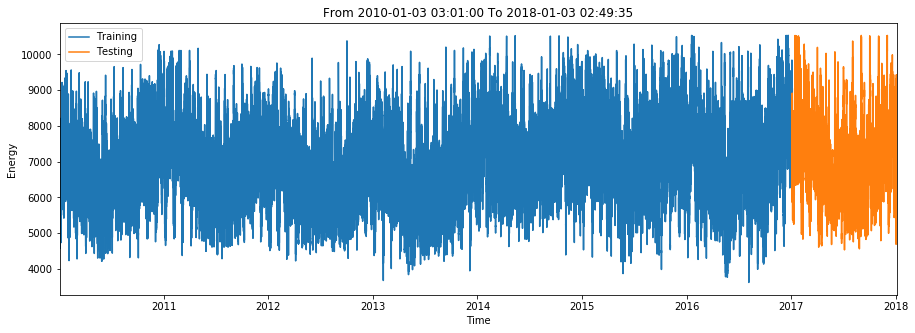

In [5]:
 dfn = pd.DataFrame(df)

from scipy import stats
dff=dfn[(np.abs(stats.zscore(dfn)) < 3).all(axis=1)]
train_df = dff[dff.index < eval_from]
test_df = dff[dff.index >= eval_from]
plot_interval(train_df, test_df, train_df.index[0], test_df.index[-1], 'Consumption_MW')
plot_interval(train_df, test_df, train_df.index[0], test_df.index[-1], 'Production_MW')

## Feature Engineering

In [6]:
## Expanding the Date column by adding some datetime related features
#from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler 
def add_datetime_features(df):
    features = ["Year", "Week", "Day", "Dayofyear", "Month", "Dayofweek",
                "Is_year_end", "Is_year_start", "Is_month_end", "Is_month_start",
                "Hour", "Minute"]

    datetime = pd.to_datetime(df.Date * (10 ** 9))
    
    for feature in features:
        new_column = getattr(datetime.dt, feature.lower())
        df[feature] = new_column
    return df

train_data = add_datetime_features(train_df.copy())
test_data = add_datetime_features(test_df.copy())

print(f"\n\t{'Column':20s} | {'Type':8s} | {'Min':12s} | {'Max':12s}\n")
#print(train_data.columns)
for col_name in train_data.columns:
    col = train_data[col_name]
    print(f"\t{col_name:20s} | {str(col.dtype):8s} | {col.min():12.1f} | {col.max():12.1f}")
      



	Column               | Type     | Min          | Max         

	Date                 | int64    | 1262487660.0 | 1483411214.0
	Consumption_MW       | float64  |       3709.0 |       9551.0
	Coal_MW              | float64  |        439.0 |       4090.0
	Gas_MW               | float64  |        116.0 |       2416.0
	Hidroelectric_MW     | float64  |          0.0 |       4102.0
	Nuclear_MW           | float64  |        651.0 |       1450.0
	Wind_MW              | float64  |        -26.0 |       2258.0
	Solar_MW             | float64  |         -6.0 |        554.0
	Biomass_MW           | float64  |          0.0 |        110.0
	Production_MW        | float64  |       3616.0 |      10536.0
	Year                 | int64    |       2010.0 |       2017.0
	Week                 | int64    |          1.0 |         53.0
	Day                  | int64    |          1.0 |         31.0
	Dayofyear            | int64    |          1.0 |        366.0
	Month                | int64    |          1.0 |    

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [8]:
data = pd.read_csv('data_electricity.csv')

In [9]:
corr = data.corr()

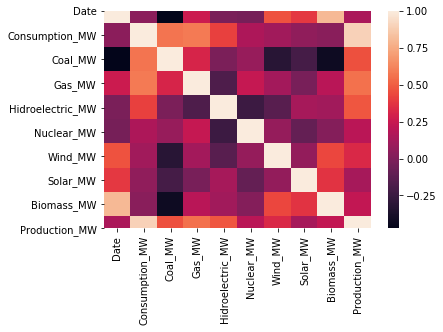

In [10]:
sns.heatmap(corr)

In [11]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = data.columns[columns]
data = data[selected_columns]

In [12]:
print(data)

              Date  Consumption_MW  Coal_MW  Gas_MW  Hidroelectric_MW  \
0       1262487660          5302.0   1754.0  1144.0            1391.0   
1       1262488200          5318.0   1777.0  1145.0            1468.0   
2       1262488800          5268.0   1743.0  1139.0            1361.0   
3       1262489400          5358.0   1759.0  1142.0            1449.0   
4       1262490060          5327.0   1764.0  1142.0            1417.0   
...            ...             ...      ...     ...               ...   
419398  1514945415          7262.0   2279.0   942.0            1444.0   
419399  1514946005          7167.0   2259.0   943.0            1383.0   
419400  1514946595          7122.0   2251.0   945.0            1362.0   
419401  1514947185          7264.0   2288.0   944.0            1454.0   
419402  1514947775          7115.0   2255.0   944.0            1370.0   

        Nuclear_MW  Wind_MW  Solar_MW  Biomass_MW  Production_MW  
0            706.0      0.0       0.0         0.0       

In [13]:
import pandas as pd
colnames=['Date', 'Consumption_MW', 'Coal_MW', 'Gas_MW', 'Hidroelectric_MW',
       'Nuclear_MW', 'Wind_MW', 'Solar_MW', 'Biomass_MW', 'Production_MW',
       'Year', 'Week', 'Day', 'Dayofyear', 'Month', 'Dayofweek', 'Is_year_end',
       'Is_year_start', 'Is_month_end', 'Is_month_start', 'Hour', 'Minute']

df = pd.read_csv("data_electricity.csv", header=None, names=colnames)
df.head()


feature_cols = ['Date', 'Consumption_MW', 'Coal_MW', 'Gas_MW', 'Hidroelectric_MW',
       'Nuclear_MW', 'Wind_MW', 'Solar_MW', 'Biomass_MW', 'Production_MW']

X = df[feature_cols] # Features
y = df.Consumption_MW # Target variable
 
#print(X)


In [14]:
# Split dataset into training set and test set

#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
#X_train, X_test, y_train, y_test = train_test_split(X, y)

In [15]:
 
to_drop = ['Date']

train_df.drop(columns=to_drop, inplace=True)
test_df.drop(columns=to_drop, inplace=True)


X_train = train_df.loc[:, train_df.columns != 'Consumption_MW'].values
X_test = test_df.loc[:, test_df.columns != 'Consumption_MW'].values

y_train = train_df.loc[:, train_df.columns == 'Consumption_MW'].values
y_test = test_df.loc[:, test_df.columns == 'Consumption_MW'].values

 
 



In [16]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor()

# Train Decision Tree  
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
predictions = clf.predict(X_test)

# Model Accuracy
print('  accuracy: ' +repr(clf.score(X_test,y_test)))

  accuracy: 0.5615192198196433


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


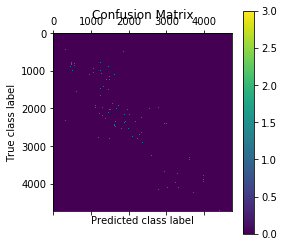

In [17]:
from sklearn.metrics import confusion_matrix
import pylab as pl
%matplotlib inline

#get confusion matrix
m = confusion_matrix(y_test, predictions)

#display matrix
print(m)

# plot confusion matrix
pl.matshow(m)
pl.title('Confusion Matrix')
pl.colorbar()
pl.ylabel('True class label')
pl.xlabel('Predicted class label')
pl.show()

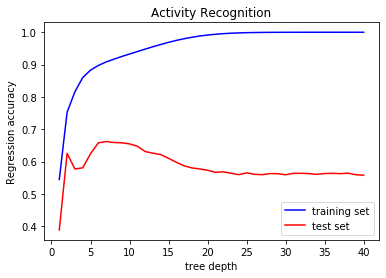

In [18]:
from sklearn.tree import DecisionTreeRegressor
import pylab as pl
training_errors = np.zeros(40)
test_errors = np.zeros(40)


for d in range(1,41):
    tree = DecisionTreeRegressor(max_depth=d)
    tree.fit(X_train,y_train)
    training_errors[d-1] = tree.score(X_train,y_train)
    test_errors[d-1] = tree.score(X_test,y_test)
    
pl.figure()
pl.plot(np.arange(1,41),training_errors,c='b',label='training set')
pl.plot(np.arange(1,41),test_errors,c='r',label='test set')
pl.xlabel("tree depth")
pl.ylabel("Regression accuracy")
pl.title("Activity Recognition")
pl.legend()
pl.show()





In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#plot data
# Fit only to the training data
scaler.fit(X_train)
# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



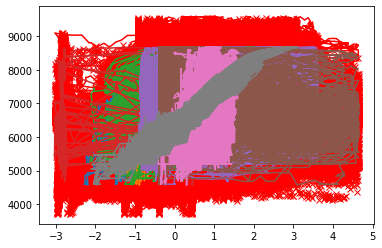

In [20]:
from sklearn.neural_network import MLPRegressor as mlp
net = mlp(hidden_layer_sizes=(50,), activation='tanh', solver='lbfgs', max_iter=2000)
net.fit(X_train,y_train)
p = net.predict(X_test)
#plot training data
plt.plot(X_train,y_train,'rx')
pl.plot(X_test,y_test,'r')
#plot target function
pl.plot(X_test,p)



[-0.06584839 -0.06584839 -0.06584839 -0.06584839 -0.06584839 -0.06584839
 -0.06584839 -0.06584839  0.29609377 -0.06584839] [ 0.00000000e+00 -2.22044605e-16 -2.22044605e-16  0.00000000e+00
 -4.44089210e-16 -2.22044605e-16  2.22044605e-16 -4.44089210e-16
  4.16832506e-01 -2.22044605e-16]


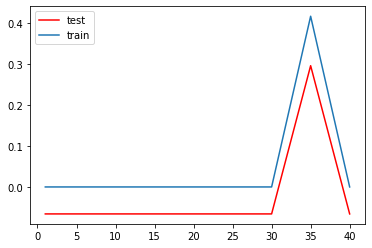

In [16]:

import matplotlib.pyplot as pl
from sklearn.neural_network import MLPRegressor as mlp
numh = [1,2,5,10,15,20,25,30,35,40]
#numh = [1,2,5]
restest = np.zeros(len(numh))
restrain = np.zeros(len(numh))

ind=0
#ideally you would run this multiple times and report average results 
#(or use cross-validation, see later)
for h in numh:
    net = mlp(hidden_layer_sizes=(h,), activation='tanh', solver='lbfgs', max_iter=2000)
    net.fit(X_train,y_train)
    restest[ind] += net.score(X_test,y_test)
    restrain[ind] += net.score(X_train,y_train)
    ind +=1

print(restest, restrain)
#plot performance
pl.figure()
pl.plot(numh,restest,'r',label='test') 
pl.plot(numh,restrain,label='train')
pl.legend()
pl.show()

In [ ]:
import numpy as np
from sklearn.neural_network import MLPRegressor as mlp

decays=[0,0.0001,0.001,0.01,0.1,1,10]
#decays=[0,0.0001]
restest = np.zeros(len(decays))
restrain = np.zeros(len(decays))
from sklearn.model_selection import cross_val_score

ind=0
for l in decays:
    net = mlp(hidden_layer_sizes=(35,), activation='tanh', 
              alpha = l, solver='lbfgs', max_iter=2000)
    scores = cross_val_score(net, X_train, y_train,
                             cv=10,scoring='neg_mean_squared_error')
    print(scores)
    net.fit(X_train,y_train)
    restest[ind] += net.score(X_test,y_test)
    restrain[ind] += net.score(X_train,y_train)
    ind+=1

#plot performance
pl.figure()
pl.plot(decays,restrain,label='train')
pl.plot(decays,restest,'r',label='test')
pl.legend()
pl.show()


[ -74885.1803735  -148080.07138584  -56110.58985358  -94454.83299329
  -92045.5089393   -65004.01764803 -161676.36486575 -129497.70133447
 -213450.32390939 -230912.38937437]
[-113127.13712441 -159790.13483906  -55525.42333047  -91457.45651571
  -97477.26911293  -69581.30085257 -160706.03765    -125457.3035097
 -206904.19893578 -212152.35186636]
[ -78811.34117065 -139506.91741116  -63049.29051674  -95805.82523744
  -83097.72886782  -71519.28493011 -142322.07194011 -122137.09723433
 -201554.54190554 -219710.8985478 ]


In [20]:
import matplotlib.pylab as plt
from sklearn import tree
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.datasets import load_boston
%matplotlib inline  
 

num_folds=10
kf = KFold(n_splits=num_folds, shuffle=True)
dt1 = tree.DecisionTreeRegressor(max_depth=1)
dt2 = tree.DecisionTreeRegressor(max_depth=20)

scores1 = cross_val_score(dt1, X_train, y_train,cv=kf,scoring='neg_mean_squared_error')
scores2 = cross_val_score(dt2, X_train, y_train,cv=kf,scoring='neg_mean_squared_error')

print("cross validation scores:")

print("mean error tree 1:" + repr(np.mean(scores1)))
print("mean error tree 2:" + repr(np.mean(scores2)))

delta_mean = np.mean(scores1-scores2)
print("mean error difference:" +repr(delta_mean))

sdelta =np.sqrt(1./(num_folds*(num_folds-1))*np.sum(((scores1-scores2)-delta_mean)**2))
    
print("error stdev estimate:" +repr(sdelta))
print("CI interval: [" +repr(delta_mean- 2.23* sdelta) 
      +","+repr(delta_mean+ 2.23* sdelta) +"]")

cross validation scores:
mean error tree 1:-452895.66322848556
mean error tree 2:-17235.441207961303
mean error difference:-435660.22202052426
error stdev estimate:917.2214914905555
CI interval: [-437705.6259465482,-433614.81809450034]


In [17]:
#Splitting of data

import pandas as pd

from sklearn.model_selection import train_test_split

data=pd.read_csv('data_electricity.csv')
data.head()


#XX = data[train_df.columns[0:9]].values
#yy = data[test_df.columns[1]].values


 


Xtrain = train_df.loc[:, train_df.columns != 'Consumption_MW'].values
Xtest = test_df.loc[:, test_df.columns != 'Consumption_MW'].values

ytrain = train_df.loc[:, train_df.columns == 'Consumption_MW'].values
ytest = test_df.loc[:, test_df.columns == 'Consumption_MW'].values

#Xtrain, Xtest, ytrain, ytest = train_test_split(XX, yy)

Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain)
#split data
#Xtrain, Xval, ytrain, yval = train_test_split(XX, yy, test_size=0.2, random_state=42)
 

Training scores:

 [       nan 1.         0.77302227 0.8685198  0.85767986 0.88820273
 0.87883265 0.81436464 0.78289455 0.82488574 0.81805475 0.68978122
 0.69728608 0.7027325  0.72201108 0.66175948 0.68526631 0.69056249
 0.66595794 0.62142031 0.64306267 0.66059752 0.65578264 0.64639685
 0.62966409 0.63173101 0.63657797 0.62923916 0.62256641 0.61074125
 0.57537352 0.59364195 0.59709633 0.5922472  0.61115495 0.614645
 0.64354623 0.64043879 0.64118408 0.63910383 0.61969763 0.60359288
 0.59926673 0.59468088 0.59557115 0.60050132 0.6071919  0.58556425
 0.58962835 0.58728276 0.56587107 0.56670413 0.55575839 0.57147021
 0.57342612 0.56526049 0.56706685 0.56160419 0.56267475 0.56310152
 0.5609633  0.55884687 0.56174345 0.55884607 0.55695212 0.54358269
 0.54348353 0.53037033 0.53485547 0.5343728  0.53302605 0.53214073
 0.53520659 0.54619888 0.54850607 0.54966267 0.54934316 0.55904933
 0.56120042 0.56145231 0.56037562 0.55778612 0.56852944 0.5608194
 0.56967004 0.56508553 0.55778962 0.56031301 0

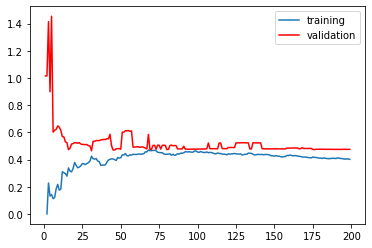

In [18]:
from sklearn import tree
num_samples = np.arange(1,200)
depth=1
trainscore = np.zeros(len(num_samples))
valscore = np.zeros(len(num_samples))
for idx,samples in enumerate(num_samples):
    model = tree.DecisionTreeRegressor(max_depth=depth)
    model.fit(Xtrain[0:samples,:],ytrain[0:samples])
    trainscore[idx] = model.score(Xtrain[0:samples,:],ytrain[0:samples])
    valscore[idx] = model.score(Xval,yval)
print('Training scores:\n\n', trainscore)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', valscore)   
plt.figure()
#plt.ylim((-0.1,0.5))
#error rate = 1.0 - accurracy
plt.plot(num_samples,1.0-trainscore,label='training')
plt.plot(num_samples,1.0-valscore,'r',label='validation')
plt.legend() 

Training scores:

 [nan  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.]

 ----------------------------------------------------------------------

Validation scores:

 [-0.01418817 -0.80491028 -0.10617303 -0.51930139  0.22803179  0.49096458
  0.

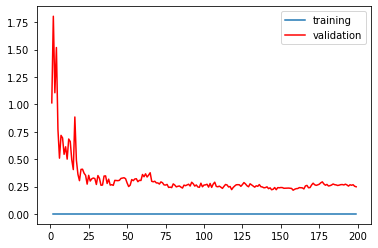

In [23]:
num_samples = np.arange(1,200)
depth=20
train_score1 = np.zeros(len(num_samples))
val_score1 = np.zeros(len(num_samples))
for idx,samples in enumerate(num_samples):
    model = tree.DecisionTreeRegressor(max_depth=depth)
    model.fit(Xtrain[0:samples,:],ytrain[0:samples])
    train_score1[idx] = model.score(Xtrain[0:samples,:],ytrain[0:samples])
    val_score1[idx] = model.score(Xval,yval)
print('Training scores:\n\n', train_score1)
print('\n', '-' * 70) 
print('\nValidation scores:\n\n', val_score1)     
plt.figure()
#plt.ylim((-0.1,0.5))
#error rate = 1.0 - accurracy
plt.plot(num_samples,1.0-train_score1,label='training')
plt.plot(num_samples,1.0-val_score1,'r',label='validation')
plt.legend() 

Training scores:

 [       nan 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1. 

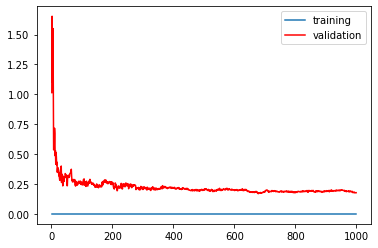

In [19]:
# With sample size 1000 and depth 20

num_samples = np.arange(1,1000)
depth=20
train_score1 = np.zeros(len(num_samples))
val_score1 = np.zeros(len(num_samples))
for idx,samples in enumerate(num_samples):
    model = tree.DecisionTreeRegressor(max_depth=depth)
    model.fit(Xtrain[0:samples,:],ytrain[0:samples])
    train_score1[idx] = model.score(Xtrain[0:samples,:],ytrain[0:samples])
    val_score1[idx] = model.score(Xval,yval)
print('Training scores:\n\n', train_score1)
print('\n', '-' * 70) 
print('\nValidation scores:\n\n', val_score1)     
plt.figure()
#plt.ylim((-0.1,0.5))
#error rate = 1.0 - accurracy
plt.plot(num_samples,1.0-train_score1,label='training')
plt.plot(num_samples,1.0-val_score1,'r',label='validation')
plt.legend() 

In [ ]:
num_samples = np.arange(1,len(yy))
depth=20
train_score1 = np.zeros(len(num_samples))
val_score1 = np.zeros(len(num_samples))
for idx,samples in enumerate(num_samples):
    model = tree.DecisionTreeRegressor(max_depth=depth)
    model.fit(Xtrain[0:samples,:],ytrain[0:samples])
    train_score1[idx] = model.score(Xtrain[0:samples,:],ytrain[0:samples])
    val_score1[idx] = model.score(Xval,yval)
print('Training scores:\n\n', train_score1)
print('\n', '-' * 70) 
print('\nValidation scores:\n\n', val_score1)     
plt.figure()
#plt.ylim((-0.1,0.5))
#error rate = 1.0 - accurracy
plt.plot(num_samples,1.0-train_score1,label='training')
plt.plot(num_samples,1.0-val_score1,'r',label='validation')
plt.legend() 

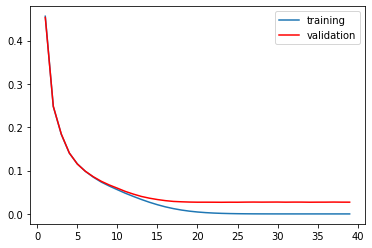

In [78]:
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor

max_d = np.arange(1,40)

train_score = np.zeros(len(max_d))
val_score = np.zeros(len(max_d))


for idx,depth in enumerate(max_d):
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(Xtrain,ytrain)
    train_score[idx] = model.score(Xtrain,ytrain)
    val_score[idx] = model.score(Xval,yval)
    
  
plt.figure()
plt.plot(max_d,1.0-train_score,label='training')
plt.plot(max_d,1.0-val_score,'r',label='validation')


plt.legend()

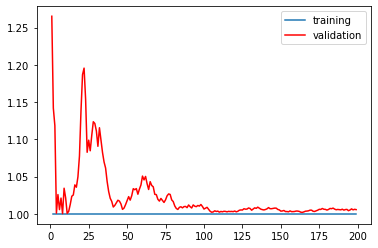

In [79]:
# Bias and variance For neural network model with sample size 200
import numpy as np
import matplotlib.pyplot as pl
from sklearn.neural_network import MLPRegressor as mlp

num_samples = np.arange(1,200)

train_scoren = np.zeros(len(num_samples))
val_scoren = np.zeros(len(num_samples))
numh = [1,2,5,10,15,20]
#numh = [1,2,5]
  
ind=0
#ideally you would run this multiple times and report average results 
#(or use cross-validation, see later)
for idx,samples in enumerate(num_samples):
    for h in numh:
        net = mlp(hidden_layer_sizes=(h,), activation='tanh', solver='lbfgs', max_iter=1000)
        net.fit(Xtrain[0:samples,:],ytrain[0:samples])
        train_scoren[idx] += net.score(Xtrain[0:samples,:],ytrain[0:samples])
        val_scoren[idx] = net.score(Xval,yval)
        ind +=1

 
 
#plot performance
pl.figure()
plt.plot(num_samples,1.0-train_scoren,label='training')
plt.plot(num_samples,1.0-val_scoren,'r',label='validation')
pl.legend()
pl.show()








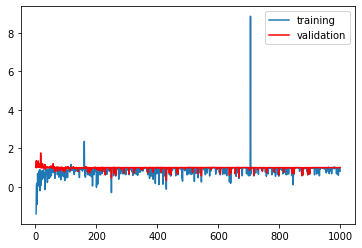

In [24]:
 #  neural network model with sample size 1000
import numpy as np
import matplotlib.pyplot as pl
from sklearn.neural_network import MLPRegressor as mlp

num_samples = np.arange(1,1000)

train_scoren = np.zeros(len(num_samples))
val_scoren = np.zeros(len(num_samples))
numh = [1,2,5,10,15,20]
#numh = [1,2,5]
  
ind=0
#ideally you would run this multiple times and report average results 
#(or use cross-validation, see later)
for idx,samples in enumerate(num_samples):
    for h in numh:
        net = mlp(hidden_layer_sizes=(h,), activation='tanh', solver='lbfgs', max_iter=1000)
        net.fit(Xtrain[0:samples,:],ytrain[0:samples])
        train_scoren[idx] += net.score(Xtrain[0:samples,:],ytrain[0:samples])
        val_scoren[idx] = net.score(Xval,yval)
        ind +=1

 
 
#plot performance
pl.figure()
plt.plot(num_samples,1.0-train_scoren,label='training')
plt.plot(num_samples,1.0-val_scoren,'r',label='validation')
pl.legend()
pl.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as pl
from sklearn.neural_network import MLPRegressor as mlp

num_samples = np.arange(1,len(yy))

train_scoren = np.zeros(len(num_samples))
val_scoren = np.zeros(len(num_samples))
numh = [1,2,5,10,15,20]
#numh = [1,2,5]
  
ind=0
#ideally you would run this multiple times and report average results 
#(or use cross-validation, see later)
for idx,samples in enumerate(num_samples):
    for h in numh:
        net = mlp(hidden_layer_sizes=(h,), activation='tanh', solver='lbfgs', max_iter=1000)
        net.fit(Xtrain[0:samples,:],ytrain[0:samples])
        train_scoren[idx] += net.score(Xtrain[0:samples,:],ytrain[0:samples])
        val_scoren[idx] = net.score(Xval,yval)
        ind +=1

 
 
#plot performance
pl.figure()
plt.plot(num_samples,1.0-train_scoren,label='training')
plt.plot(num_samples,1.0-val_scoren,'r',label='validation')
pl.legend()
pl.show()







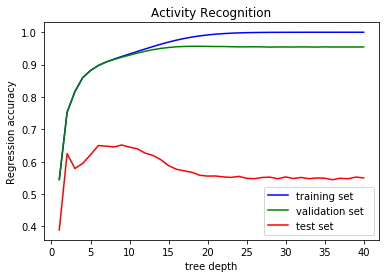

In [28]:
# Decision tree

from sklearn.tree import DecisionTreeRegressor
import pylab as pl
training_errors = np.zeros(40)
test_errors = np.zeros(40)
vali_errors = np.zeros(40)


for d in range(1,41):
    tree = DecisionTreeRegressor(max_depth=d)
    tree.fit(Xtrain,ytrain)
    training_errors[d-1] = tree.score(Xtrain,ytrain)
    
    vali_errors[d-1] = tree.score(Xval,yval)
    test_errors[d-1] = tree.score(Xtest,ytest)
    
pl.figure()
pl.plot(np.arange(1,41),training_errors,c='b',label='training set  ')

pl.plot(np.arange(1,41),vali_errors,c='g',label='validation set  ')
pl.plot(np.arange(1,41),test_errors,c='r',label='test set  ')
pl.xlabel("tree depth")
pl.ylabel("Regression accuracy")
pl.title("Activity Recognition")
pl.legend()
pl.show()


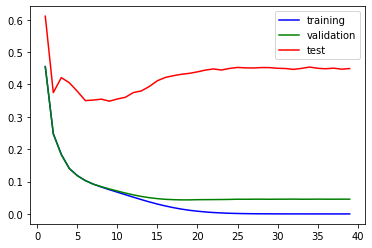

In [20]:
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor

max_d = np.arange(1,40)

train_score = np.zeros(len(max_d))
val_score = np.zeros(len(max_d))
test_score = np.zeros(len(max_d))


for idx,depth in enumerate(max_d):
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(Xtrain,ytrain)
    train_score[idx] = model.score(Xtrain,ytrain)
    
    test_score[idx] = model.score(Xtest,ytest)
    val_score[idx] = model.score(Xval,yval)
    
  
plt.figure()
plt.plot(max_d,1.0-train_score,'b',label='training')
plt.plot(max_d,1.0-val_score,'g',label='validation')

plt.plot(max_d,1.0-test_score,'r',label='test')


plt.legend()

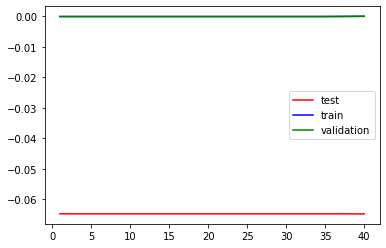

In [22]:
# For Artificial neural network

 
import matplotlib.pyplot as pl
import numpy as np
from sklearn.neural_network import MLPRegressor as mlp
numh = [1,2,5,10,15,20,25,30,35,40]
#numh = [1,2,5]
restest = np.zeros(len(numh))
restrain = np.zeros(len(numh))
resval = np.zeros(len(numh))

ind=0
#ideally you would run this multiple times and report average results 
#(or use cross-validation, see later)
for h in numh:
    net = mlp(hidden_layer_sizes=(h,), activation='tanh', solver='lbfgs', max_iter=2000)
    net.fit(Xtrain,ytrain)
    
    restrain[ind] += net.score(Xtrain,ytrain)
    restest[ind] += net.score(Xtest,ytest)
    resval[ind] += net.score(Xval,yval)
    ind +=1

 
 
pl.figure()
pl.plot(numh,restest,'r',label='test') 
pl.plot(numh,restrain,'b',label='train')
pl.plot(numh,resval,'g',label='validation')
pl.legend()
pl.show()

## Minimum Requirements

You will need to proprocess the given data and then train at least 2 different models on the data set. Make sure to include the reason for your choice (e.g., for solving a regression problem). Please refer to the handbook Ch.5 and WPO on Evaluation Hypothesis to find the proper methodology to train your models

* Perform at least the following pre-processing steps for your data: remove outliers and feature selection.
* Train at least 2 models (e.g. decision trees and nearest neighbour) to predict electricity consumption. You are allowed to use: Decision Trees, Perceptrons, Neural Networks, K Nearest Neighbours or Naive Bayes models (all of these are available in scikit learn library). You are also allowed to use other methods, as long as you document and motivate your choice.
* For each model, optimize the model parameters settings (tree depth, hidden nodes/decay, number of neighbours,...). Show which parameter setting gives the best expected error.
* Analyse bias and variance for both model types. Plot learning curves to demonstrate the model performance. (See WPO on Evaluation Hypothesis)
* Compare the best parameter settings for both models and estimate their errors on unseen data. Can you show that one of the models performs better?

All results, plots and code should be handed in as an interactive <a href='http://ipython.org/notebook.html'>iPython notebook</a>. Simply providing code and plots does not suffice, you are expected to accompany each technical section by explanations and discussions on your choices/results/observation/etc. <b>The deadline for the assignment is 19/01/2020</b>.

## Optional Extensions

You are encouraged to try and see if you can further improve on the models you obtained above. This is not necessary to obtain a good grade on the assignment, but any extensions on the minimum requirements will count for extra credit. Some suggested possibilities to extend your approach are:


* Try to combine multiple models. Ensemble and boosting methods try to combine the predictions of many, simple models. This typically works best with models that make different errors. Scikit-learn has some support for this, <a href="http://scikit-learn.org/stable/modules/ensemble.html">see here</a>. You can also try to combine the predictions of multiple models manually, i.e. train multiple models and average their predictions.
* Notice that for this project you need to deal with sequential data. You can always employ feature engineering  targeted for cyclical data (e.g., hours, days, months).

## Additional Remarks

* Depending on the model used, you may want to <a href='http://scikit-learn.org/stable/modules/preprocessing.html'>scale</a> features X and/or outputs Y.
* Refer to the <a href='http://scipy.org/docs.html'>SciPy</a> and <a href='http://scikit-learn.org/stable/documentation.html'>Scikit learn</a> documentations for more information on classifiers and data handling.
* You are allowed to use additional libraries, but provide references for these.
* This assignment will be graded and will count for part of your final grade (25%).
* The assignment is **individual**. All results should be your own. Plagiarism will not be tolerated.